In [ ]:
#importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

#printing there version
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version() if torch.cuda.is_available() else 'N/A'}")
print(f"Device count: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device() if torch.cuda.is_available() else 'CPU'}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Data Transformation
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Load the full dataset first
data_dir = '/kaggle/input/indian-500rs-currency-dataset/indian currency'
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Dataset split sizes
total_size = len(full_dataset)
test_size = int(0.2 * total_size)  # 20% for testing
train_size = total_size - test_size

# Split the dataset
train_data, test_data = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Check classes to confirm
print(f"Classes: {full_dataset.classes}")
print(f"Class to index mapping: {full_dataset.class_to_idx}")


In [18]:
#LOAD TRAINED RESNET18 MODEL

import torch
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model architecture
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

# Freeze all layer
for param in model.parameters():
    param.requires_grad = False

# Replacing final layer with my 2 classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # FAKE, REAL

# Move to device
model = model.to(device)

# Load saved weights
model.load_state_dict(torch.load('/kaggle/input/output-file/currency_classifier_resnet18.pth', map_location=device))

print("✅ Model loaded successfully with trained weights.")


✅ Model loaded successfully with trained weights.


In [19]:
#Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [ ]:
#Training loop
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct.double() / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# saving model
torch.save(model.state_dict(), "currency_classifier_resnet18.pth")
print("Model saved successfully.")


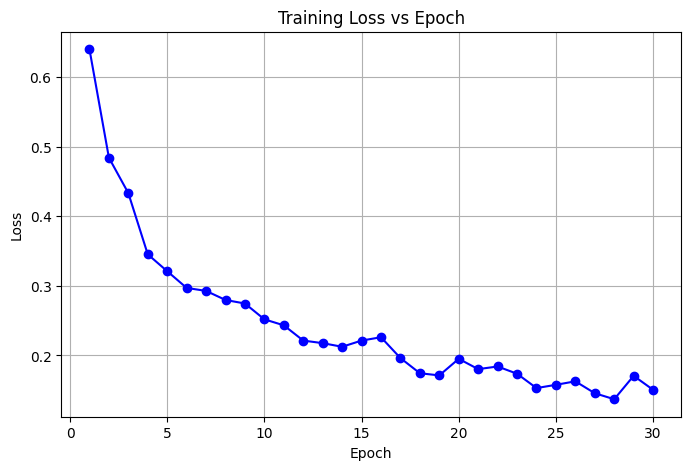

In [13]:
#Plotting loss from log file

import matplotlib.pyplot as plt

# Path to your log file
log_path = '/kaggle/input/log-file1/download (1).txt'

# Lists to store epoch numbers and loss values
epochs = []
losses = []

# Read file and extract data
with open(log_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'Epoch' in line and 'Loss' in line:
            parts = line.split('-')
            epoch_part = parts[0].strip()
            loss_part = parts[1].strip()
            
            # Extract epoch number
            epoch_num = int(epoch_part.split('[')[1].split('/')[0])
            # Extract loss value
            loss_value = float(loss_part.split(':')[1].split(',')[0].strip())
            
            epochs.append(epoch_num)
            losses.append(loss_value)


plt.figure(figsize=(8,5))
plt.plot(epochs, losses, marker='o', color='blue')
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


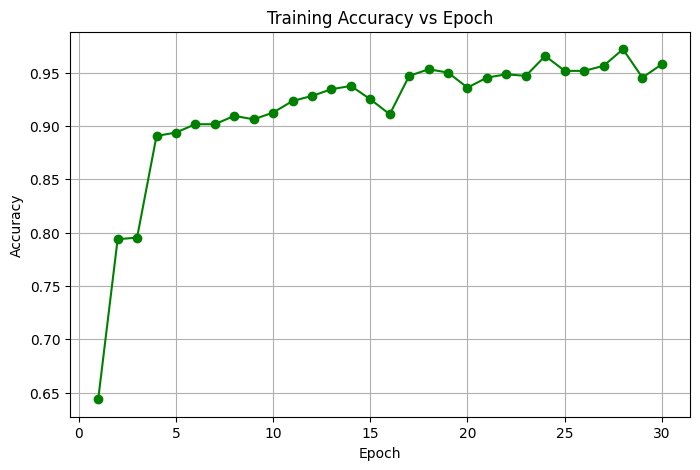

In [15]:
# Plotting Accuracy from Log File

import matplotlib.pyplot as plt

# Path to your log file
log_path = '/kaggle/input/log-file1/download (1).txt'

# Lists to store epoch numbers and accuracy values
epochs = []
accuracies = []

# Read file and extract data
with open(log_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if 'Epoch' in line and 'Accuracy' in line:
            parts = line.split('-')
            epoch_part = parts[0].strip()
            loss_acc_part = parts[1].strip()
            
            # Extract epoch number
            epoch_num = int(epoch_part.split('[')[1].split('/')[0])
            
            # Extract accuracy value
            if 'Accuracy:' in loss_acc_part:
                acc_value = float(loss_acc_part.split('Accuracy:')[1].strip())
            else:
                acc_value = None  

            if acc_value is not None:
                epochs.append(epoch_num)
                accuracies.append(acc_value)

# Plotting the accuracy graph using matplotlib
plt.figure(figsize=(8,5))
plt.plot(epochs, accuracies, marker='o', color='green')
plt.title('Training Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [20]:

#Image prediction block
from PIL import Image
def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
        predicted_class = class_names[pred.item()]
    
    return predicted_class

# image path
img_path = '/kaggle/input/500-inr-for-test/500.jpg'


prediction = predict_image(img_path, model, transform, full_dataset.classes)

if(prediction=="FAKE 500"):
    print("Fake Currency detected-500INR")
else:
    print("Real Currency-500INR")




Real Currency-500INR


In [21]:
#Testing block
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9308
